In [1]:
import numpy as np
import pickle
import math
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

In [2]:
#################################################################################################
#                                                                                               #
# Preprocessing functions that can be useful for NLP projects.  I have broken out all of the    #
# individual functions so each can be independently tested if we want to.  I have created a     #
# normalize function that does the basic combination of proprocessing steps like lowercase,     #
# whitespace cleaning, etc.  I then created a Preprocessing function that uses normalize and    #
# then removes the stopwords and lemmatizes.                                                    #
#################################################################################################

# import the necessary libraries
import re
import string

import contractions
import inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
#nltk.download('wordnet')
#nltk.download('omw-1.4')


# Lowercase the text function
def text_lowercase(text):
    return text.lower()


# Remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result


# convert numbers into words
def convert_number(text):
    inflect_engine = inflect.engine()

    # split string into list of words
    temp_str = text.split()
    # initialise empty list
    new_string = []

    for word in temp_str:
        # if word is a digit, convert the digit
        # to numbers and append into the new_string list
        if word.isdigit():
            temp = inflect_engine.number_to_words(word)
            new_string.append(temp)

        # append the word as it is
        else:
            new_string.append(word)

    # join the words of new_string to form a string
    temp_str = ' '.join(new_string)
    return temp_str


# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


# remove whitespace from text
def remove_whitespace(text):
    return " ".join(text.split())


# Replace contractions in string of text
def replace_contractions(text):
    return contractions.fix(text)


# Remove URLs from a sample string
def remove_URL(sample):
    result = sample
    if type(sample) != str:
        result= str(sample)
    return re.sub(r"http\S+", "", result)
    

# remove stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text


# Check if each character in string is ASCII
# The first 128 unicode code points represent the ASCII characters.
def remove_non_ascii(text):
    return ''.join(char for char in text if ord(char) < 128)


# Lemmatize verbs in list of tokenized words
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []

    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)

    return lemmas


def normalize(words):
    words = remove_URL(words)
    words = remove_non_ascii(words)
    words = text_lowercase(words)
    words = remove_punctuation(words)
    words = remove_whitespace(words)
    words = replace_contractions(words)
    words = remove_numbers(words)

    return words


# Preprocess text
def preprocess_text(corpus):
    # Normalize all the text
    text = normalize(corpus)

    # Remove the stop words
    text = remove_stopwords(text)
    #
    # # Lemmatize and tokenize the text
    text = lemmatize_verbs(text)

    return text

In [3]:
unclean_insurance_data = pd.read_csv(".\data\InjuryCauseTopThirteen.csv")
print("rdy")

rdy


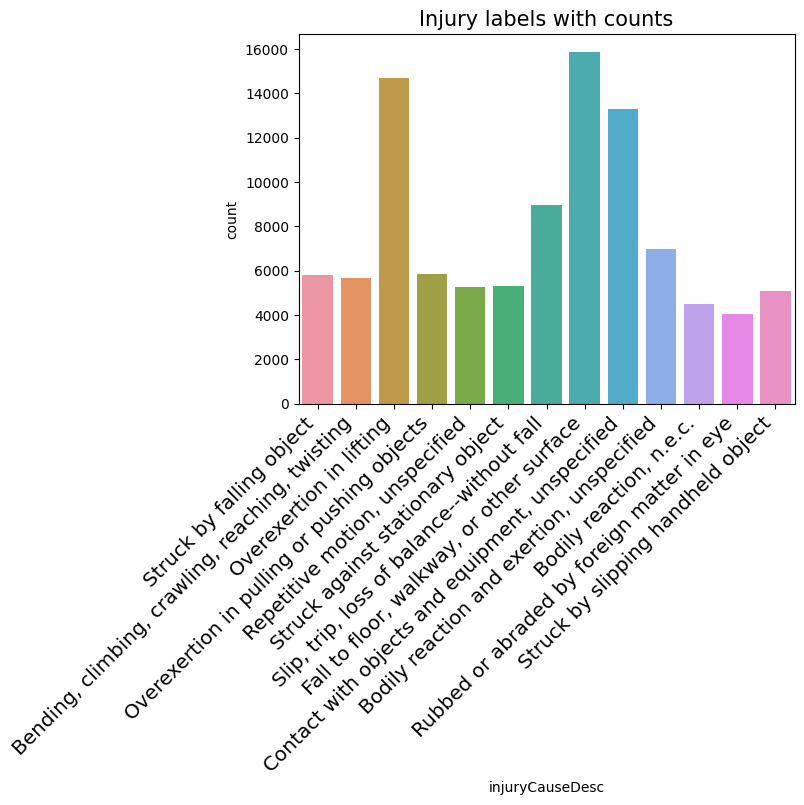

In [4]:
#Bar Chart of the labels
plt.figure(figsize = None)
chart = sns.countplot(x = 'injuryCauseDesc', data = unclean_insurance_data)
plt.title("Injury labels with counts", fontsize = 15)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

plt.show()

In [5]:
unclean_insurance_data.injuryCauseDesc.value_counts()

Fall to floor, walkway, or other surface           15882
Overexertion in lifting                            14716
Contact with objects and equipment, unspecified    13317
Slip, trip, loss of balance--without fall           8953
Bodily reaction and exertion, unspecified           6972
Overexertion in pulling or pushing objects          5868
Struck by falling object                            5796
Bending, climbing, crawling, reaching, twisting     5673
Struck against stationary object                    5329
Repetitive motion, unspecified                      5257
Struck by slipping handheld object                  5102
Bodily reaction, n.e.c.                             4509
Rubbed or abraded by foreign matter in eye          4037
Name: injuryCauseDesc, dtype: int64

In [6]:
#minimize data to lowest value
min_samples = 4037

fall  = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Fall to floor, walkway, or other surface'].sample(min_samples, random_state = 2022)
over_lift = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Overexertion in lifting'].sample(min_samples, random_state = 2022)
contact  = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Contact with objects and equipment, unspecified'].sample(min_samples, random_state = 2022)
slip = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Slip, trip, loss of balance--without fall'].sample(min_samples, random_state = 2022)
bodily = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Bodily reaction and exertion, unspecified'].sample(min_samples, random_state = 2022)
over_pull = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Overexertion in pulling or pushing objects'].sample(min_samples, random_state = 2022)
struck_fall = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Struck by falling object'].sample(min_samples, random_state = 2022)
bending = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Bending, climbing, crawling, reaching, twisting'].sample(min_samples, random_state = 2022)
struck_against = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Struck against stationary object'].sample(min_samples, random_state = 2022)
repetitive_motion  = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Repetitive motion, unspecified'].sample(min_samples, random_state = 2022)
struck_slip  = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Struck by slipping handheld object'].sample(min_samples, random_state = 2022)
bodily_reaction  = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Bodily reaction, n.e.c.'].sample(min_samples, random_state = 2022)
rubbed = unclean_insurance_data[unclean_insurance_data['injuryCauseDesc'] =='Rubbed or abraded by foreign matter in eye'].sample(min_samples, random_state = 2022)

print('rdy')

rdy


In [ ]:
#oversampling method
oversampled = []
df_majority = bodily 

listie = [fall, over_lift, contact, bodily, over_pull, struck_fall, bending,
          struck_against, repetitive_motion, struck_slip, bodily_reaction, rubbed]


for category in listie: 
    
    df_minority = category
    over_sample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)
    
    oversampled.append(over_sample)

In [7]:
#combine all the categories
balanced_insurance_df = pd.concat([fall, over_lift, contact, slip,  over_pull, 
                                   struck_fall, bending, struck_against, repetitive_motion,
                                   struck_slip, rubbed])
balanced_insurance_df.injuryCauseDesc.value_counts()

Fall to floor, walkway, or other surface           4037
Overexertion in lifting                            4037
Contact with objects and equipment, unspecified    4037
Slip, trip, loss of balance--without fall          4037
Overexertion in pulling or pushing objects         4037
Struck by falling object                           4037
Bending, climbing, crawling, reaching, twisting    4037
Struck against stationary object                   4037
Repetitive motion, unspecified                     4037
Struck by slipping handheld object                 4037
Rubbed or abraded by foreign matter in eye         4037
Name: injuryCauseDesc, dtype: int64

In [8]:
#map categories
target = {'Fall to floor, walkway, or other surface': 0,
          'Overexertion in lifting': 1,
          'Contact with objects and equipment, unspecified': 2,
          'Slip, trip, loss of balance--without fall': 3,
          'Bodily reaction and exertion, unspecified': 4,
          'Overexertion in pulling or pushing objects': 5,
          'Struck by falling object': 6,
          'Bending, climbing, crawling, reaching, twisting': 7,
          'Struck against stationary object': 8,
          'Repetitive motion, unspecified': 9,
          'Struck by slipping handheld object': 10,
          'Bodily reaction, n.e.c.': 11,
          'Rubbed or abraded by foreign matter in eye': 12,
         }
          
balanced_insurance_df['injuryCauseDesc_num']  = balanced_insurance_df.injuryCauseDesc.map(target)

print('rdy')

rdy


In [9]:
#split
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(
    balanced_insurance_df.InjuryDesc,
    balanced_insurance_df.injuryCauseDesc_num,
    test_size = 0.2,
    random_state = 2022,
    #stratify=balanced_insurance_df.injuryCauseDesc_num
    )

print('rdy')

rdy


In [10]:
#Run first default SVM

from sklearn import svm

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics

print("DATA: TEST + Balanced-Down, MODEL: SVM, VECTORIZER: TF-IDF\n")
print(classification_report(y_test, y_pred))

DATA: TEST + Balanced-Down, MODEL: SVM, VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       777
           1       0.76      0.79      0.78       793
           2       0.51      0.51      0.51       771
           3       0.72      0.67      0.69       817
           5       0.73      0.73      0.73       787
           6       0.83      0.82      0.82       844
           7       0.72      0.70      0.71       811
           8       0.74      0.66      0.70       836
           9       0.84      0.89      0.86       807
          10       0.77      0.83      0.80       815
          12       0.95      0.92      0.93       824

    accuracy                           0.75      8882
   macro avg       0.75      0.75      0.75      8882
weighted avg       0.75      0.75      0.75      8882



In [32]:
#Test for overfitting


from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))

# Display metrics

print("DATA: Training + Balanced-Down, MODEL: SVM, VECTORIZER: TF-IDF\n")
print(classification_report(y_train, y_pred))

DATA: Training + Balanced-Down, MODEL: SVM, VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3260
           1       0.94      0.96      0.95      3244
           2       0.88      0.81      0.85      3266
           3       0.94      0.91      0.92      3220
           5       0.95      0.96      0.95      3250
           6       0.96      0.97      0.96      3193
           7       0.96      0.92      0.94      3226
           8       0.95      0.91      0.93      3201
           9       0.97      0.98      0.97      3230
          10       0.89      0.95      0.92      3222
          12       0.98      0.99      0.98      3213

    accuracy                           0.94     35525
   macro avg       0.94      0.94      0.94     35525
weighted avg       0.94      0.94      0.94     35525



In [12]:
#SVM is overfitting with default hyper-parameters
# cls = SVC(kernel='linear', C= .1) potential to resolve overfitting

In [28]:
vectorizer = TfidfVectorizer(ngram_range =(1,3))
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .1)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.1), VECTORIZER: TF-IDF + ngram_range =(1,3)\n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.1), VECTORIZER: TF-IDF + ngram_range =(1,3)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       777
           1       0.82      0.68      0.75       793
           2       0.47      0.56      0.51       771
           3       0.70      0.67      0.69       817
           5       0.66      0.72      0.69       787
           6       0.77      0.84      0.81       844
           7       0.63      0.68      0.66       811
           8       0.76      0.63      0.69       836
           9       0.82      0.87      0.84       807
          10       0.79      0.73      0.76       815
          12       0.95      0.91      0.93       824

    accuracy                           0.73      8882
   macro avg       0.74      0.73      0.73      8882
weighted avg       0.74      0.73      0.73      8882



In [33]:
vectorizer = TfidfVectorizer(ngram_range =(1,3))
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .2)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,3)\n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,3)

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       777
           1       0.80      0.76      0.78       793
           2       0.51      0.54      0.53       771
           3       0.71      0.68      0.70       817
           5       0.70      0.72      0.71       787
           6       0.82      0.86      0.84       844
           7       0.68      0.67      0.67       811
           8       0.78      0.65      0.71       836
           9       0.81      0.88      0.84       807
          10       0.79      0.80      0.79       815
          12       0.95      0.92      0.93       824

    accuracy                           0.75      8882
   macro avg       0.75      0.75      0.75      8882
weighted avg       0.75      0.75      0.75      8882



In [30]:
#Best hyperparameter combination found here




vectorizer = TfidfVectorizer(ngram_range =(1,2))
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .2)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,2)\n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,2)

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       777
           1       0.80      0.77      0.78       793
           2       0.50      0.53      0.52       771
           3       0.72      0.69      0.70       817
           5       0.71      0.73      0.72       787
           6       0.84      0.86      0.85       844
           7       0.69      0.69      0.69       811
           8       0.78      0.66      0.72       836
           9       0.81      0.89      0.85       807
          10       0.78      0.80      0.79       815
          12       0.95      0.92      0.93       824

    accuracy                           0.76      8882
   macro avg       0.76      0.75      0.75      8882
weighted avg       0.76      0.76      0.76      8882



In [31]:
#Test to check if model is overfitting. 


vectorizer = TfidfVectorizer(ngram_range =(1,2))
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .2)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))



print("DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,2)\n")
print(classification_report(y_train, y_pred))

DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,2)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      3260
           1       0.86      0.83      0.84      3244
           2       0.60      0.67      0.63      3266
           3       0.77      0.77      0.77      3220
           5       0.82      0.84      0.83      3250
           6       0.88      0.91      0.89      3193
           7       0.77      0.79      0.78      3226
           8       0.85      0.72      0.78      3201
           9       0.87      0.92      0.89      3230
          10       0.83      0.80      0.81      3222
          12       0.96      0.94      0.95      3213

    accuracy                           0.82     35525
   macro avg       0.82      0.82      0.82     35525
weighted avg       0.82      0.82      0.82     35525



In [ ]:
#Various hyperparameters experiments below. 

In [ ]:
unclean_insurance_data

In [40]:
target = {'Fall to floor, walkway, or other surface': 0,
          'Overexertion in lifting': 1,
          'Contact with objects and equipment, unspecified': 2,
          'Slip, trip, loss of balance--without fall': 3,
          'Bodily reaction and exertion, unspecified': 4,
          'Overexertion in pulling or pushing objects': 5,
          'Struck by falling object': 6,
          'Bending, climbing, crawling, reaching, twisting': 7,
          'Struck against stationary object': 8,
          'Repetitive motion, unspecified': 9,
          'Struck by slipping handheld object': 10,
          'Bodily reaction, n.e.c.': 11,
          'Rubbed or abraded by foreign matter in eye': 12,
         }
          
unclean_insurance_data['injuryCauseDesc_num']  = unclean_insurance_data.injuryCauseDesc.map(target)

print('rdy')

rdy


In [41]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(
    unclean_insurance_data.InjuryDesc,
    unclean_insurance_data.injuryCauseDesc_num,
    test_size = 0.2,
    random_state = 2022,
    #stratify=balanced_insurance_df.injuryCauseDesc_num
    )

print('rdy')

rdy


In [42]:
vectorizer = TfidfVectorizer(ngram_range =(1,2))
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .2)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,2)\n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.2), VECTORIZER: TF-IDF + ngram_range =(1,2)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      3132
           1       0.67      0.89      0.76      2962
           2       0.59      0.75      0.66      2714
           3       0.68      0.60      0.64      1776
           4       0.35      0.34      0.34      1433
           5       0.75      0.53      0.62      1173
           6       0.84      0.77      0.80      1137
           7       0.64      0.45      0.53      1145
           8       0.73      0.48      0.58      1083
           9       0.68      0.75      0.71      1043
          10       0.68      0.54      0.60      1003
          11       0.62      0.13      0.21       906
          12       0.86      0.93      0.90       776

    accuracy                           0.68     20283
   macro avg       0.68      0.62      0.63     20283
weighted avg       0.68    

In [ ]:
## experiments below

In [15]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= 500.0)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: TEST + Balanced-Down, MODEL: SVM (kernel='linear', C= 500.0), VECTORIZER: TF-IDF\n")
print(classification_report(y_test, y_pred))


DATA: TEST + Balanced-Down, MODEL: SVM (kernel='linear', C= 500.0), VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       777
           1       0.63      0.70      0.66       793
           2       0.34      0.45      0.39       771
           3       0.58      0.55      0.56       817
           5       0.63      0.62      0.62       787
           6       0.79      0.73      0.76       844
           7       0.59      0.56      0.57       811
           8       0.64      0.54      0.58       836
           9       0.81      0.82      0.82       807
          10       0.70      0.61      0.65       815
          12       0.94      0.86      0.90       824

    accuracy                           0.65      8882
   macro avg       0.66      0.65      0.65      8882
weighted avg       0.66      0.65      0.65      8882



In [16]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= 500.0)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))



print("DATA: Training + Balanced-Down, MODEL: SVM (kernel='linear', C= 500.0), VECTORIZER: TF-IDF\n")
print(classification_report(y_train, y_pred))

DATA: Training + Balanced-Down, MODEL: SVM (kernel='linear', C= 500.0), VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3260
           1       0.99      1.00      1.00      3244
           2       0.97      0.94      0.96      3266
           3       0.97      0.96      0.97      3220
           5       1.00      1.00      1.00      3250
           6       1.00      1.00      1.00      3193
           7       1.00      0.99      1.00      3226
           8       0.99      0.99      0.99      3201
           9       0.99      1.00      1.00      3230
          10       0.95      0.98      0.96      3222
          12       1.00      1.00      1.00      3213

    accuracy                           0.99     35525
   macro avg       0.99      0.99      0.99     35525
weighted avg       0.99      0.99      0.99     35525



In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= 50.0)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: TEST + Balanced-Down, MODEL: SVM (kernel='linear', C= 50.0), VECTORIZER: TF-IDF\n")
print(classification_report(y_test, y_pred))

DATA: TEST + Balanced-Down, MODEL: SVM (kernel='linear', C= 50.0), VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       777
           1       0.65      0.73      0.69       793
           2       0.37      0.45      0.41       771
           3       0.62      0.60      0.61       817
           5       0.65      0.63      0.64       787
           6       0.80      0.75      0.77       844
           7       0.65      0.61      0.63       811
           8       0.68      0.58      0.63       836
           9       0.82      0.85      0.83       807
          10       0.72      0.68      0.70       815
          12       0.94      0.89      0.91       824

    accuracy                           0.68      8882
   macro avg       0.68      0.68      0.68      8882
weighted avg       0.69      0.68      0.68      8882



In [18]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= 50.0)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))



print("DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 50.0), VECTORIZER: TF-IDF\n")
print(classification_report(y_train, y_pred))

DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 50.0), VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3260
           1       0.98      0.99      0.98      3244
           2       0.95      0.91      0.93      3266
           3       0.96      0.95      0.96      3220
           5       0.99      0.99      0.99      3250
           6       1.00      1.00      1.00      3193
           7       0.99      0.98      0.98      3226
           8       0.98      0.97      0.98      3201
           9       0.99      1.00      0.99      3230
          10       0.93      0.97      0.95      3222
          12       1.00      1.00      1.00      3213

    accuracy                           0.97     35525
   macro avg       0.97      0.97      0.97     35525
weighted avg       0.97      0.97      0.97     35525



In [34]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= 1.0)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))



print("DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 1.0), VECTORIZER: TF-IDF\n")
print(classification_report(y_train, y_pred))

DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 1.0), VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3260
           1       0.86      0.90      0.88      3244
           2       0.73      0.68      0.70      3266
           3       0.83      0.81      0.82      3220
           5       0.87      0.88      0.88      3250
           6       0.89      0.93      0.91      3193
           7       0.87      0.81      0.84      3226
           8       0.87      0.81      0.83      3201
           9       0.92      0.94      0.93      3230
          10       0.83      0.89      0.86      3222
          12       0.96      0.97      0.97      3213

    accuracy                           0.86     35525
   macro avg       0.86      0.86      0.86     35525
weighted avg       0.86      0.86      0.86     35525



In [35]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .1)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.1), VECTORIZER: TF-IDF\n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.1), VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       777
           1       0.80      0.75      0.78       793
           2       0.48      0.54      0.51       771
           3       0.70      0.67      0.69       817
           5       0.72      0.73      0.73       787
           6       0.80      0.80      0.80       844
           7       0.68      0.71      0.69       811
           8       0.72      0.63      0.67       836
           9       0.81      0.89      0.85       807
          10       0.77      0.78      0.78       815
          12       0.95      0.92      0.93       824

    accuracy                           0.74      8882
   macro avg       0.74      0.74      0.74      8882
weighted avg       0.74      0.74      0.74      8882



In [36]:
vectorizer = TfidfVectorizer(ngram_range =(1,2))
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .1)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.1), VECTORIZER: TF-IDF + ngram_range =(1,2) \n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='linear', C= 0.1), VECTORIZER: TF-IDF + ngram_range =(1,2) 

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       777
           1       0.82      0.73      0.78       793
           2       0.48      0.56      0.52       771
           3       0.70      0.68      0.69       817
           5       0.69      0.73      0.71       787
           6       0.81      0.84      0.83       844
           7       0.65      0.69      0.67       811
           8       0.76      0.64      0.70       836
           9       0.81      0.88      0.84       807
          10       0.79      0.75      0.77       815
          12       0.95      0.91      0.93       824

    accuracy                           0.74      8882
   macro avg       0.75      0.74      0.74      8882
weighted avg       0.75      0.74      0.74      8882



In [37]:
vectorizer = TfidfVectorizer(ngram_range =(1,2))
vectorizer.fit(X_train)

cls = SVC(kernel='rbf', C= .1)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='rbf', C= 0.1), VECTORIZER: TF-IDF + ngram_range =(1,2)\n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='rbf', C= 0.1), VECTORIZER: TF-IDF + ngram_range =(1,2)

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       777
           1       0.86      0.58      0.69       793
           2       0.41      0.62      0.50       771
           3       0.70      0.64      0.67       817
           5       0.54      0.78      0.64       787
           6       0.72      0.84      0.78       844
           7       0.65      0.65      0.65       811
           8       0.71      0.61      0.66       836
           9       0.84      0.83      0.84       807
          10       0.82      0.59      0.69       815
          12       0.96      0.88      0.92       824

    accuracy                           0.70      8882
   macro avg       0.73      0.70      0.70      8882
weighted avg       0.73      0.70      0.70      8882



In [27]:
vectorizer = TfidfVectorizer(ngram_range =(1,2))
vectorizer.fit(X_train)

cls = SVC(kernel='poly', C= .1)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))



print("DATA: Test + Balanced-Down, MODEL: SVM (kernel='poly', C= 0.1), VECTORIZER: TF-IDF + ngram(1,2)\n")
print(classification_report(y_test, y_pred))

DATA: Test + Balanced-Down, MODEL: SVM (kernel='poly', C= 0.1), VECTORIZER: TF-IDF + ngram(1,2)

              precision    recall  f1-score   support

           0       0.75      0.05      0.09       777
           1       1.00      0.01      0.01       793
           2       0.09      0.99      0.16       771
           3       0.00      0.00      0.00       817
           5       0.00      0.00      0.00       787
           6       0.00      0.00      0.00       844
           7       1.00      0.00      0.00       811
           8       0.00      0.00      0.00       836
           9       0.87      0.03      0.06       807
          10       0.93      0.05      0.09       815
          12       1.00      0.02      0.05       824

    accuracy                           0.10      8882
   macro avg       0.51      0.10      0.04      8882
weighted avg       0.51      0.10      0.04      8882



c:\users\vmshk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\vmshk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\vmshk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [38]:
vectorizer = TfidfVectorizer(ngram_range =(1,2))
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .1)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))



print("DATA: Train + Balanced-Down, MODEL: SVM (kernel='linear', C= .1, VECTORIZER: TF-IDF + ngram_range =(1,2)\n")
print(classification_report(y_train, y_pred))

DATA: Train + Balanced-Down, MODEL: SVM (kernel='linear', C= .1, VECTORIZER: TF-IDF + ngram_range =(1,2)

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      3260
           1       0.85      0.75      0.80      3244
           2       0.52      0.66      0.58      3266
           3       0.72      0.74      0.73      3220
           5       0.76      0.81      0.78      3250
           6       0.84      0.87      0.86      3193
           7       0.70      0.76      0.73      3226
           8       0.81      0.67      0.73      3201
           9       0.85      0.89      0.87      3230
          10       0.82      0.72      0.77      3222
          12       0.95      0.92      0.94      3213

    accuracy                           0.78     35525
   macro avg       0.79      0.78      0.78     35525
weighted avg       0.79      0.78      0.78     35525



In [39]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC(kernel='linear', C= .1)

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))



print("DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 50.0), VECTORIZER: TF-IDF\n")
print(classification_report(y_train, y_pred))

DATA: TRAIN + Balanced-Down, MODEL: SVM (kernel='linear', C= 50.0), VECTORIZER: TF-IDF

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      3260
           1       0.81      0.77      0.79      3244
           2       0.53      0.59      0.56      3266
           3       0.72      0.73      0.72      3220
           5       0.76      0.77      0.77      3250
           6       0.81      0.83      0.82      3193
           7       0.71      0.73      0.72      3226
           8       0.76      0.67      0.71      3201
           9       0.84      0.89      0.87      3230
          10       0.79      0.77      0.78      3222
          12       0.95      0.93      0.94      3213

    accuracy                           0.76     35525
   macro avg       0.77      0.77      0.77     35525
weighted avg       0.77      0.76      0.77     35525



In [ ]:
from sklearn import svm

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

clf = Pipeline([
        ('vectorizer_tf', TfidfVectorizer()),
        ('svm', svm.SVC(kernel='rbf', C= 500.0))
])

clf.fit(X_train, y_train)
    

y_pred = clf.predict(X_train)

print("DATA: CLEAN + Balanced-Down, MODEL: SVM, VECTORIZER: TF-IDF\n")
print(classification_report(y_train, y_pred))
print('rdy')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(unbalanced_insurance_df['InjuryDesc'],
                                                    unbalanced_insurance_df['injuryCauseDesc_num'],
                                                    random_state=0)

In [41]:



vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3989
           1       0.97      0.98      0.97      3684
           2       0.96      0.94      0.95      3306

    accuracy                           0.97     10979
   macro avg       0.97      0.97      0.97     10979
weighted avg       0.97      0.97      0.97     10979



In [38]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

cls = SVC()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_train))

# Display metrics

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     11924
           1       0.93      0.98      0.95     11116
           2       0.87      0.90      0.88      9999
           3       0.94      0.84      0.89      6657
           5       0.95      0.90      0.92      4371
           6       0.95      0.95      0.95      4287
           7       0.95      0.86      0.91      4234
           8       0.93      0.81      0.87      4008
           9       0.96      0.97      0.96      3978
          10       0.88      0.85      0.86      3812
          12       0.95      0.97      0.96      3061

    accuracy                           0.92     67447
   macro avg       0.93      0.91      0.92     67447
weighted avg       0.92      0.92      0.92     67447



In [17]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(
    unbalanced_insurance_df.InjuryDesc,
    unbalanced_insurance_df.injuryCauseDesc_num,
    test_size = 0.3,
    random_state = 2022,
    #stratify=balanced_insurance_df.injuryCauseDesc_num
    )

print('rdy')

rdy


In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

clf = Pipeline([
        ('vectorizer_tf', CountVectorizer()),
        ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)
    

y_pred = clf.predict(X_test)

print("DATA-TEST: UNCLEAN + Unbalanced, MODEL: NB, VECTORIZER: Count \n")
print(classification_report(y_test, y_pred))

DATA-TEST: UNCLEAN + Unbalanced, MODEL: NB, VECTORIZER: Count 

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      4714
           1       0.73      0.90      0.81      4409
           2       0.62      0.66      0.64      3971
           3       0.64      0.50      0.56      2661
           5       0.77      0.47      0.58      1827
           6       0.70      0.66      0.68      1717
           7       0.76      0.46      0.58      1747
           8       0.68      0.43      0.53      1598
           9       0.81      0.85      0.83      1624
          10       0.63      0.66      0.64      1487
          12       0.91      0.89      0.90      1224

    accuracy                           0.71     26979
   macro avg       0.72      0.67      0.68     26979
weighted avg       0.71      0.71      0.70     26979



In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

clf = Pipeline([
        ('vectorizer_tf', CountVectorizer()),
        ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)
    

y_pred = clf.predict(X_train)

print("DATA-TRAINING: UNCLEAN + Unbalanced, MODEL: NB, VECTORIZER: Count \n")
print(classification_report(y_train, y_pred))

DATA-TRAINING: UNCLEAN + Unbalanced, MODEL: NB, VECTORIZER: Count 

              precision    recall  f1-score   support

           0       0.75      0.91      0.82     12733
           1       0.79      0.92      0.85     11801
           2       0.68      0.70      0.69     10656
           3       0.73      0.58      0.64      7171
           5       0.84      0.60      0.70      4667
           6       0.76      0.75      0.76      4669
           7       0.83      0.55      0.66      4515
           8       0.76      0.54      0.63      4263
           9       0.83      0.87      0.85      4199
          10       0.66      0.71      0.68      4075
          12       0.92      0.92      0.92      3195

    accuracy                           0.76     71944
   macro avg       0.78      0.73      0.75     71944
weighted avg       0.76      0.76      0.75     71944



In [ ]:
### just SVM

In [34]:
from sklearn import svm

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

clf = Pipeline([
        ('vectorizer_tf', CountVectorizer()),
        ('svm', svm.SVC())
])

clf.fit(X_train, y_train)
    

y_pred = clf.predict(X_test)

print("DATA: UNCLEAN , MODEL: SVM, VECTORIZER: CountVectorizer\n")
print(classification_report(y_test, y_pred))
print('rdy')

DATA: UNCLEAN , MODEL: SVM, VECTORIZER: CountVectorizer

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      3149
           1       0.74      0.91      0.82      2915
           2       0.63      0.73      0.68      2661
           3       0.73      0.63      0.68      1782
           5       0.79      0.58      0.67      1201
           6       0.80      0.74      0.77      1127
           7       0.75      0.57      0.65      1158
           8       0.73      0.53      0.61      1066
           9       0.82      0.82      0.82      1058
          10       0.71      0.58      0.64      1027
          12       0.90      0.88      0.89       842

    accuracy                           0.75     17986
   macro avg       0.76      0.71      0.73     17986
weighted avg       0.75      0.75      0.74     17986

rdy


In [ ]:
clf = Pipeline([
        ('vectorizer_tf', CountVectorizer()),
        ('svm', svm.SVC())
])

clf.fit(X_train, y_train)
    

y_pred = clf.predict(X_train)

print("DATA: UNCLEAN , MODEL: SVM, VECTORIZER: CountVectorizer\n")
print(classification_report(y_train, y_pred))
print('rdy')